# NLP EDA

Text Data Exploration Techniques

- [Term Frequency](#Term-Frequency)
- [Ngrams](#Ngrams)
- [Document Length](#Document-Length)
- [Word Cloud](#Word-Cloud)
- [Sentiment Analysis](#Sentiment-Analysis)

## Setup

In [ ]:
from typing import List
import unicodedata
import re

import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 8))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)

def clean(text: str) -> List[str]:
    "a simple function to prepare text data"
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words("english") + ["r", "u", "2", "ltgt"]
    text = (
        unicodedata.normalize("NFKD", text)
        .encode("ascii", "ignore")
        .decode("utf-8", "ignore")
        .lower()
    )
    words = re.sub(r"[^\w\s]", "", text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

df = pd.read_csv("spam_clean.csv")

A quick data summary

In [ ]:
df.shape

In [ ]:
df.isna().sum()

In [ ]:
df.text

What percentage of the data is spam?

,n,percent
ham,4825,0.865937
spam,747,0.134063


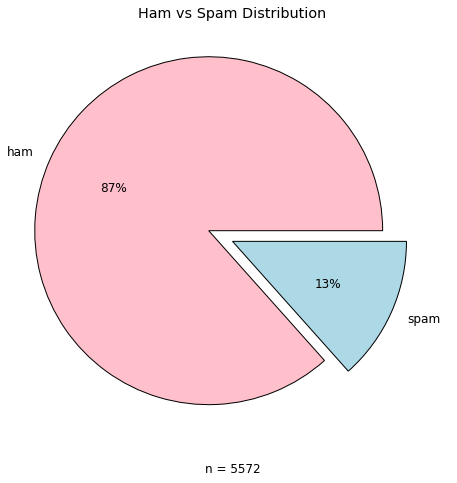

In [3]:
df.label.value_counts().plot.pie(
    colors=["pink", "lightblue"], explode=(0.15, 0), autopct="%.0f%%"
)
plt.title("Ham vs Spam Distribution")
plt.ylabel("")
plt.xlabel("n = %d" % df.shape[0])

pd.concat(
    [df.label.value_counts(), df.label.value_counts(normalize=True)], axis=1
).set_axis(["n", "percent"], axis=1, inplace=False)

## Term Frequency

In [ ]:
pd.Series(" ".join(df.text).split()).value_counts()

1. one big string for everything, spam, ham
1. lists of strings
1. list of strings -> pandas series so we can value count
1. combine series into single dataframe

In [4]:
all_text = " ".join(df.text)
spam_text = " ".join(df[df.label == "spam"].text)
ham_text = " ".join(df[df.label == "ham"].text)

In [ ]:
spam_text

In [5]:
all_words = clean(all_text)
spam_words = clean(spam_text)
ham_words = clean(ham_text)

In [6]:
all_freq = pd.Series(all_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
ham_freq = pd.Series(ham_words).value_counts()

In [ ]:
spam_freq

In [7]:
tf = (
    pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
    .rename(columns={0: "all", 1: "ham", 2: "spam"})
    .fillna(0)
    .apply(lambda col: col.astype(int))
)

- most common words overall?
- most common spam, ham words?
- any words that uniquely spam or ham?

In [ ]:
tf.sort_values(by="all").tail(10)

In [ ]:
tf.sort_values(by='all')['all'].tail(10).plot.barh(width=.9)
plt.title('10 most common words')

In [ ]:
tf.sort_values(by='spam').spam.tail(10).plot.barh(width=1, color='brown')
plt.title('10 most common spam words')

In [ ]:
tf.sort_values(by='ham').ham.tail(10).plot.barh(width=1, color='pink')
plt.title('What are the most common words for ham (i.e. non-spam) texts?')

## Ngrams

- bigrams + viz most frequent for all, spam, ham
- trigrams, etc

In [8]:
list(nltk.bigrams('I love the smell of regex in the morning'.split()))

[('I', 'love'),
 ('love', 'the'),
 ('the', 'smell'),
 ('smell', 'of'),
 ('of', 'regex'),
 ('regex', 'in'),
 ('in', 'the'),
 ('the', 'morning')]

In [ ]:
list(nltk.ngrams('I love the smell of regex in the morning'.split(), 3))

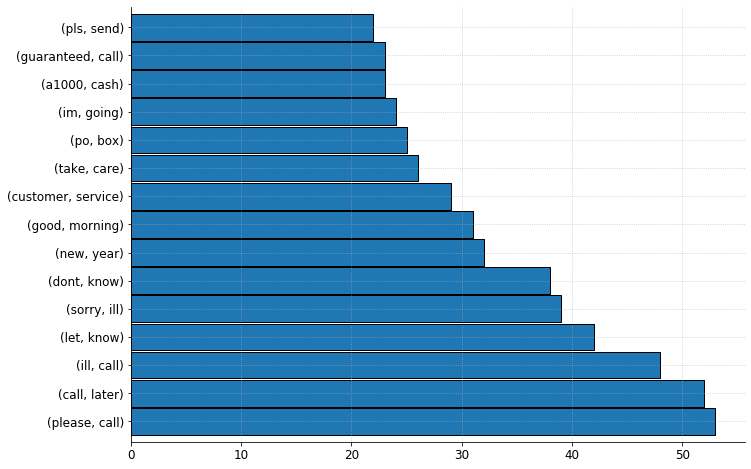

In [9]:
pd.Series(nltk.bigrams(all_words)).value_counts().head(15).plot.barh(width=.95)

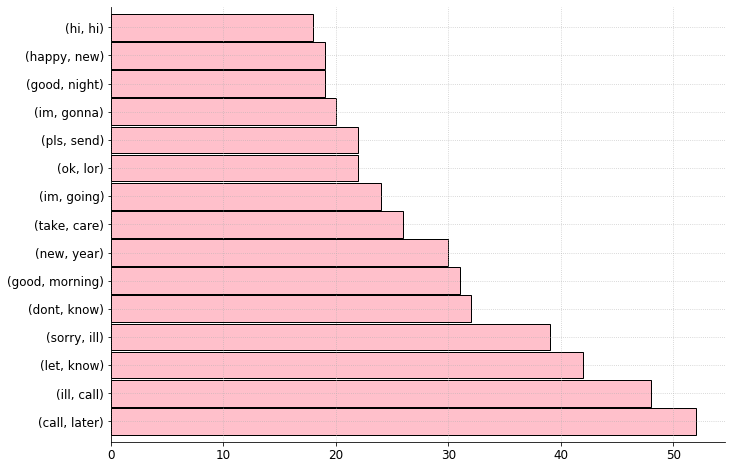

In [10]:
pd.Series(nltk.bigrams(ham_words)).value_counts().head(15).plot.barh(width=.95, color='pink')

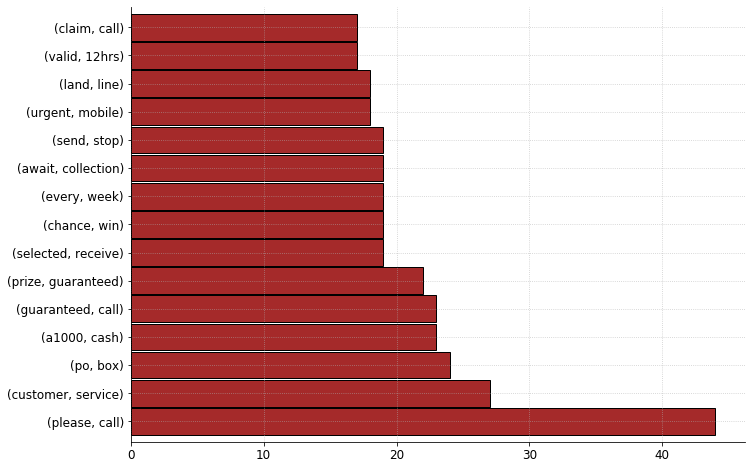

In [11]:
pd.Series(nltk.bigrams(spam_words)).value_counts().head(15).plot.barh(width=.95, color='brown')

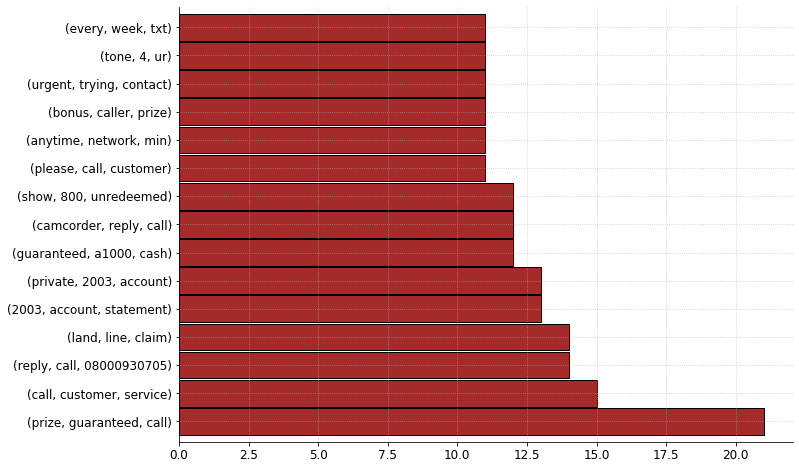

In [12]:
pd.Series(nltk.ngrams(spam_words, 3)).value_counts().head(15).plot.barh(width=.95, color='brown')

## Document Length

In [13]:
df["message_length"] = df.text.apply(len)

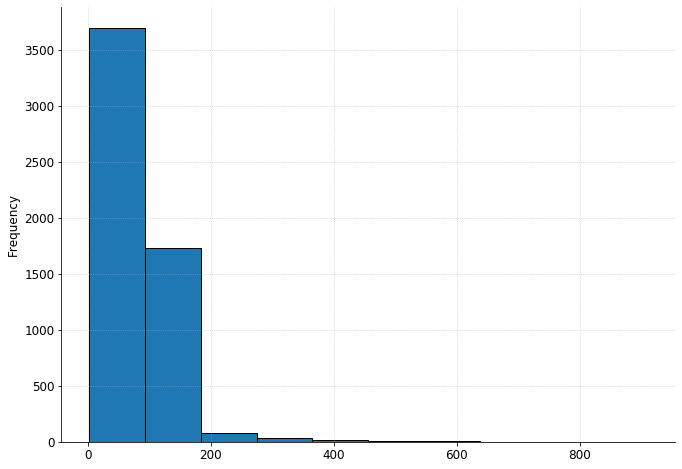

In [15]:
df.message_length.plot.hist()

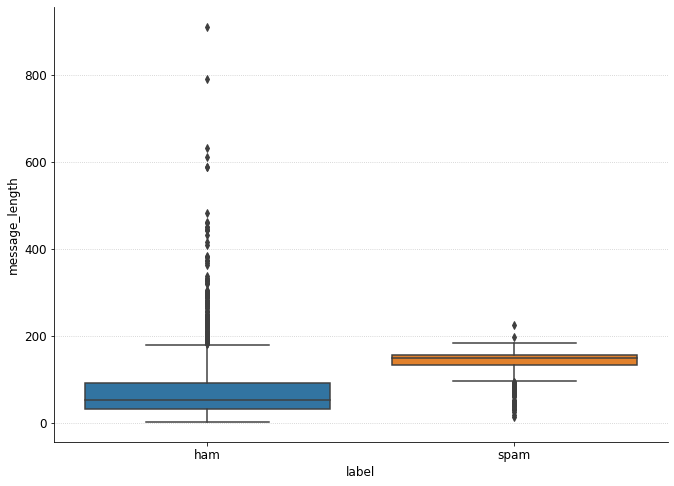

In [16]:
sns.boxplot(data=df, y="message_length", x="label")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a22352a58>,
      dtype=object)

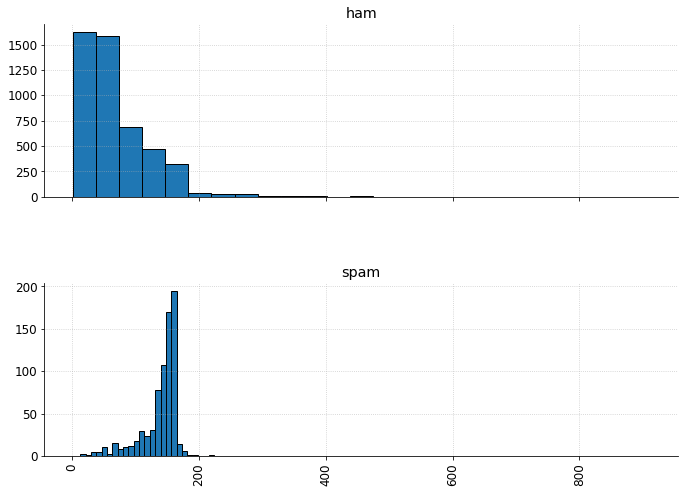

In [17]:
df.hist("message_length", by="label", sharex=True, layout=(2, 1), bins=25)

### Number of Words

In [18]:
df["n_words"] = df.text.str.count(r"\w+")

In [20]:
df.groupby("label").n_words.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4825.0,14.677098,11.738398,0.0,7.0,11.0,19.0,190.0
spam,747.0,25.821954,6.073204,2.0,24.0,27.0,30.0,40.0


Text(0.5, 0.98, 'Distribution of Number of Words for Spam and Ham Messages')

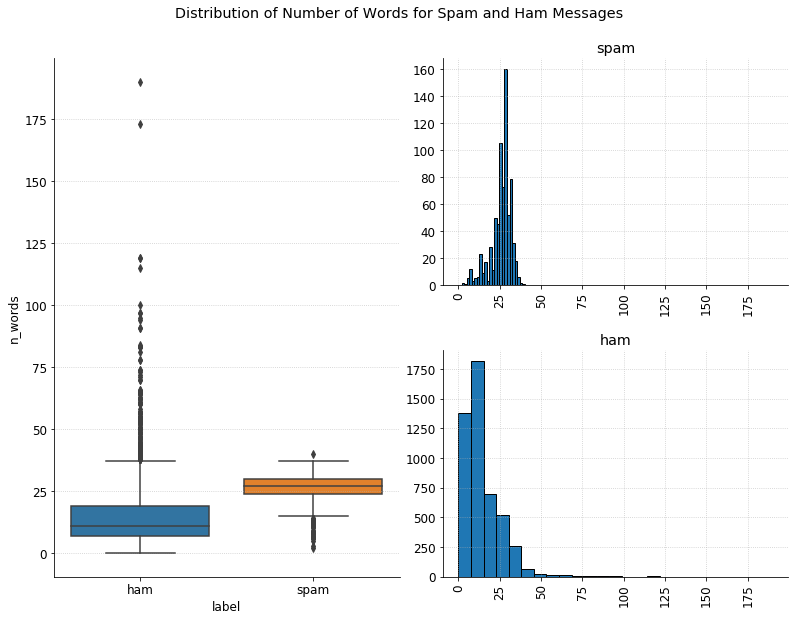

In [23]:
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_axes([0.1, 0.1, 0.4, 0.8])  # left, bottom, width, height
ax2 = fig.add_axes([0.55, 0.1, 0.4, 0.35])
ax3 = fig.add_axes([0.55, 0.55, 0.4, 0.35], sharex=ax2)
sns.boxplot(data=df, y="n_words", x="label", ax=ax1)
df.hist("n_words", by="label", bins=25, ax=[ax2, ax3])
fig.suptitle("Distribution of Number of Words for Spam and Ham Messages")

## Word Cloud

`WordCloud()` produces an image object, which can be displayed with `plt.imshow`

(-0.5, 399.5, 199.5, -0.5)

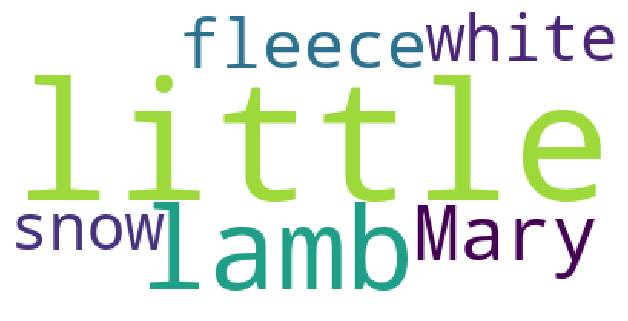

In [36]:
from wordcloud import WordCloud

sentence = (
    "Mary had a little lamb, little lamb, little lamb. Its fleece was white as snow."
)
img = WordCloud(background_color="white", random_state=123).generate(sentence)
plt.imshow(img)
plt.axis("off")

do the same with all words, spam and ham

(-0.5, 1199.5, 799.5, -0.5)

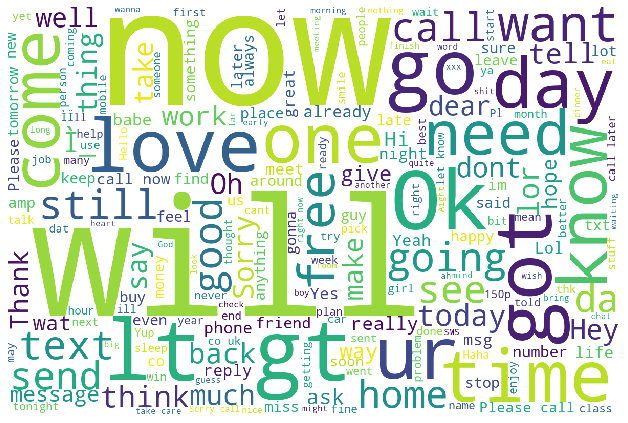

In [38]:
img = WordCloud(background_color="white", height=800, width=1200).generate(all_text)
plt.imshow(img)
plt.axis("off")

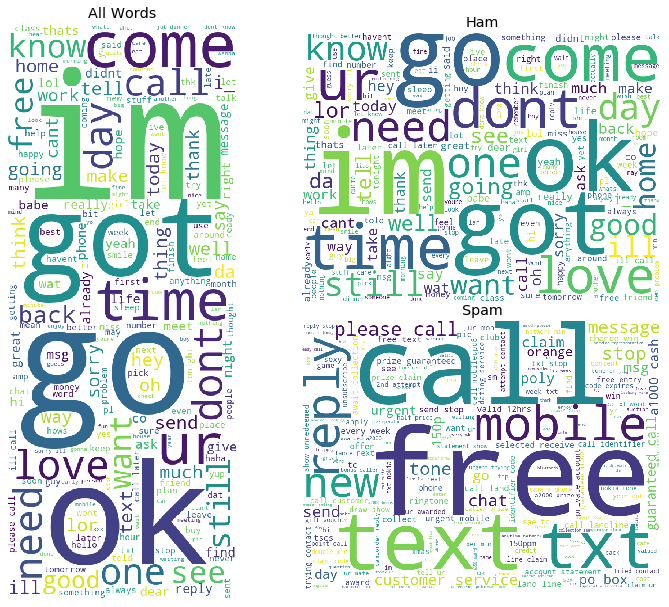

In [39]:
all_cloud = WordCloud(background_color="white", height=1000, width=400).generate(
    " ".join(all_words)
)
ham_cloud = WordCloud(background_color="white", height=600, width=800).generate(
    " ".join(ham_words)
)
spam_cloud = WordCloud(background_color="white", height=600, width=800).generate(
    " ".join(spam_words)
)

plt.figure(figsize=(10, 8))
axs = [
    plt.axes([0, 0, 0.5, 1]),
    plt.axes([0.5, 0.5, 0.5, 0.5]),
    plt.axes([0.5, 0, 0.5, 0.5]),
]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title("All Words")
axs[1].set_title("Ham")
axs[2].set_title("Spam")

for ax in axs:
    ax.axis("off")

### Word Cloud with Bigrams

- `generate_from_frequencies` + python gymnastics

(-0.5, 399.5, 199.5, -0.5)

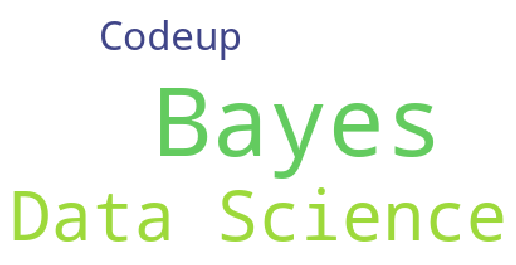

In [41]:
frequencies = {
    "Codeup": 1,
    "Bayes": 12,
    "Data Science": 6,
}

img = WordCloud(background_color="white").generate_from_frequencies(frequencies)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")

In [43]:
top_20_ham_bigrams = pd.Series(nltk.bigrams(ham_words)).value_counts().head(20)
top_20_ham_bigrams

(call, later)      52
(ill, call)        48
(let, know)        42
(sorry, ill)       39
(dont, know)       32
(good, morning)    31
(new, year)        30
(take, care)       26
(im, going)        24
(ok, lor)          22
(pls, send)        22
(im, gonna)        20
(good, night)      19
(happy, new)       19
(hi, hi)           18
(last, night)      18
(wat, time)        18
(great, day)       17
(nice, day)        15
(want, go)         15
dtype: int64

In [45]:
data = {p1 + " " + p2: v for (p1, p2), v in top_20_ham_bigrams.to_dict().items()}
data

{'call later': 52,
 'ill call': 48,
 'let know': 42,
 'sorry ill': 39,
 'dont know': 32,
 'good morning': 31,
 'new year': 30,
 'take care': 26,
 'im going': 24,
 'ok lor': 22,
 'pls send': 22,
 'im gonna': 20,
 'good night': 19,
 'happy new': 19,
 'hi hi': 18,
 'last night': 18,
 'wat time': 18,
 'great day': 17,
 'nice day': 15,
 'want go': 15}

(-0.5, 1599.5, 1199.5, -0.5)

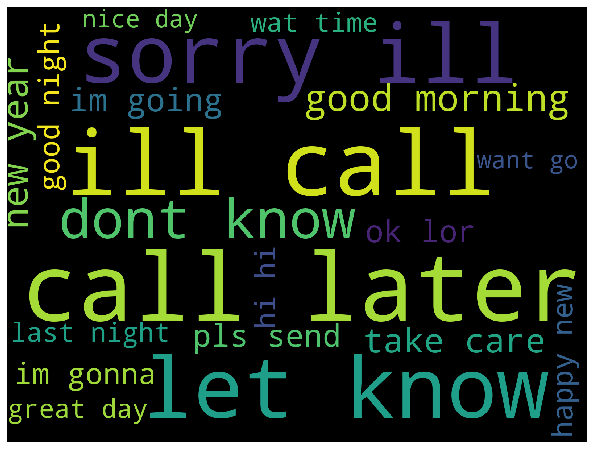

In [51]:
img = WordCloud(
    background_color="black", width=1600, height=1200
).generate_from_frequencies(data)

plt.figure(figsize=(16, 8))
plt.imshow(img)
plt.axis("off")

## Sentiment Analysis

A way for us to put a number to indicate whether a document has a positive or
negative sentiment.

### Vader

In [52]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

In [53]:
sia.polarity_scores("Sentiment analysis is very awesome!")

{'neg': 0.0, 'neu': 0.461, 'pos': 0.539, 'compound': 0.6893}

In [54]:
sia.polarity_scores("I am pretty worried about bad weather this weekend.")

{'neg': 0.41, 'neu': 0.36, 'pos': 0.23, 'compound': -0.3612}

In [60]:
df["vader_sentiment"] = df.text.apply(lambda txt: sia.polarity_scores(txt)["compound"])

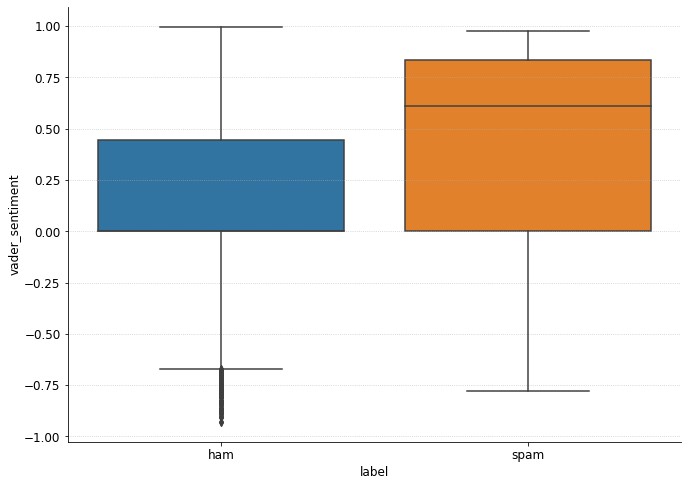

In [61]:
sns.boxplot(data=df, y="vader_sentiment", x="label")

In [ ]:
df.groupby("label").vader_sentiment.describe()

### Afinn

In [62]:
from afinn import Afinn

sa = Afinn()

In [63]:
sa.score("Sentiment analysis is very awesome!")

4.0

In [64]:
sa.score("I am pretty worried about bad weather this weekend.")

-5.0

In [65]:
df["afinn_sentiment"] = df.text.apply(sa.score)

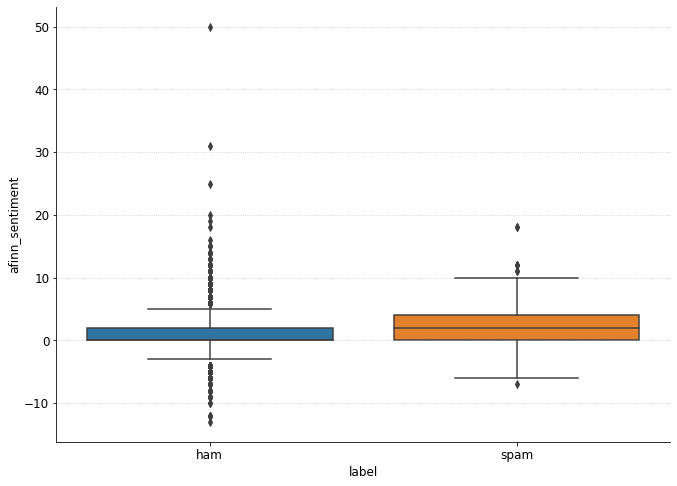

In [66]:
sns.boxplot(data=df, y="afinn_sentiment", x="label")

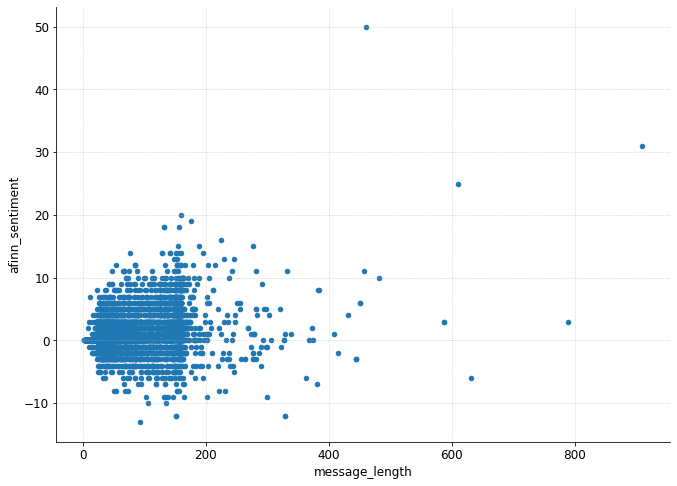

In [67]:
df.plot.scatter(y='afinn_sentiment', x='message_length')

In [69]:
from scipy.stats import pearsonr

pearsonr(df.message_length, df.afinn_sentiment)

(0.2517878327439385, 2.563658698130022e-81)

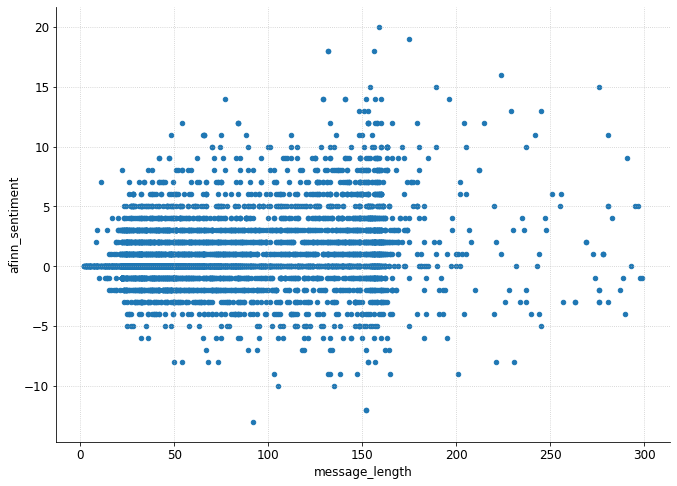

In [68]:
df[df.message_length < 300].plot.scatter(y='afinn_sentiment', x='message_length')

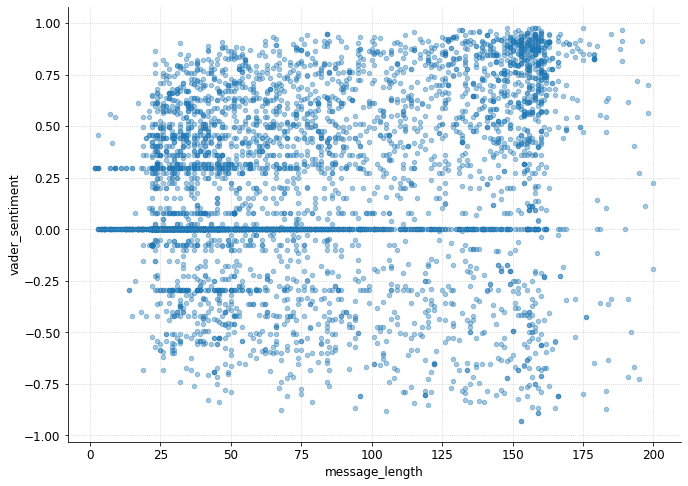

In [72]:
df[df.message_length <= 200].plot.scatter(y='vader_sentiment', x='message_length', alpha=.4)

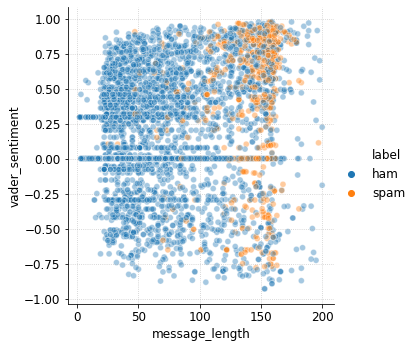

In [77]:
sns.relplot(data=df[df.message_length <= 200], y='vader_sentiment', x='message_length', hue='label', alpha=.4)

In [ ]:
df.groupby("label").afinn_sentiment.describe()

## Further Reading

- [VADER Sentiment Analysis](https://github.com/cjhutto/vaderSentiment)
- [AFINN Sentiment Analysis](https://github.com/fnielsen/afinn)

## Other NLP Libraries

- [spaCy](https://spacy.io/)
- [textacy](https://chartbeat-labs.github.io/textacy/) builds on top of spaCy
- [TextBlob](https://textblob.readthedocs.io/en/dev/)

## Bonus Exercises

After you've worked through the exercises in the curriculum,

- Use sentiment analysis to explore your datasets. Which news category has the highest sentiment? Which has the lowest? Does this match with what you might predict?

- Create a feature named `has_long_words`. This should be either true or false depending on whether or not the message contains a word greater than 5 characters. Use this feature to explore spam v ham. What changes if you change the cutoff from 5 to 8 characters?

- Explore the enron spam email dataset

    Download [the json file located here](https://ds.codeup.com/enron_spam.json.gz) and read it with pandas:
    
    We have done a little preprocessing and acquisition of the [data found in this kaggle competition](https://www.kaggle.com/wanderfj/enron-spam) to make it easier to work with.
    
    ```python
    df = pd.read_json("enron_spam.json.gz")
    ```
    
    Start by focusing just on the `label`, `subject`, and `text` columns.